 Problem Statement: Beyond detection, assess the potential impact score of a fake news article
 using natural language features, social media metrics (shares, likes), and sentiment polarity.

| Column Name             | Type             | Description                                                                                                                                                                     |
| ----------------------- | ---------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **article\_id**         | Integer          | Unique identifier for each article.                                                                                                                                             |
| **title\_length**       | Integer          | Number of characters in the article title/headline. Longer titles may indicate sensationalism.                                                                                  |
| **text\_length**        | Integer          | Number of characters in the full article body. Helps capture verbosity/detail.                                                                                                  |
| **num\_shares**         | Integer          | Number of times the article was shared on social media.                                                                                                                         |
| **num\_likes**          | Integer          | Number of likes the article received on social media platforms.                                                                                                                 |
| **num\_comments**       | Integer          | Number of user comments the article generated.                                                                                                                                  |
| **sentiment\_score**    | Float (-1 to +1) | Sentiment polarity of the article text: **-1 = very negative, 0 = neutral, +1 = very positive**.                                                                                |
| **subjectivity**        | Float (0 to 1)   | Subjectivity of the article: **0 = objective/factual, 1 = highly opinionated**.                                                                                                 |
| **source\_reliability** | Integer (1–10)   | Credibility rating of the news source: **1 = very unreliable, 10 = highly reliable**.                                                                                           |
| **impact\_score**       | Float (0–100)    |  A computed score representing the potential impact of the fake news article, influenced by engagement (shares, likes, comments), sentiment, and reliability. |


Target Column-impact_score

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
import random
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [5]:
# Set seed for reproducibility
np.random.seed(42)

# Number of samples
n = 500000

# Fake dataset columns
data = {
    "article_id": np.arange(1, n+1),
    "title_length": np.random.randint(20, 150, n),        # length of headline/title
    "text_length": np.random.randint(200, 2000, n),       # length of article body
    "num_shares": np.random.randint(0, 10000, n),         # social media shares
    "num_likes": np.random.randint(0, 20000, n),          # social media likes
    "num_comments": np.random.randint(0, 5000, n),        # user comments
    "sentiment_score": np.round(np.random.uniform(-1, 1, n), 2),  # -1 (negative) to +1 (positive)
    "subjectivity": np.round(np.random.uniform(0, 1, n), 2),      # 0 (objective) to 1 (subjective)
    "source_reliability": np.random.randint(1, 10, n),    # 1=low credibility, 10=high
}

df = pd.DataFrame(data)

# Target variable: Fake News Impact Score (0–100)
# Formula mixing influence of shares, likes, comments, sentiment, reliability
df["impact_score"] = (
    (df["num_shares"]*0.3 + df["num_likes"]*0.2 + df["num_comments"]*0.2) / 300 
    + (df["sentiment_score"]*10) 
    + (10 - df["source_reliability"]) * 2
    + np.random.normal(0, 5, n)   # noise
).clip(0, 100)   # keep score in range [0,100]


df.to_csv("fake_news_impact_dataset.csv", index=False)


In [6]:
df.head()

,article_id,title_length,text_length,num_shares,num_likes,num_comments,sentiment_score,subjectivity,source_reliability,impact_score
0,1,122,1401,6162,10086,4927,0.12,0.44,9,15.749509
1,2,112,778,3384,10222,4145,0.76,0.33,8,22.413467
2,3,34,441,3434,2759,1794,-0.63,0.10,6,9.419026
3,4,126,1594,3306,4655,2880,0.04,0.26,8,14.423110
4,5,91,621,5037,5020,910,0.86,0.99,7,24.117044


In [7]:
df.shape

(500000, 10)

In [11]:
df.describe()

,article_id,title_length,text_length,num_shares,num_likes,num_comments,sentiment_score,subjectivity,source_reliability,impact_score
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,250000.500000,84.431048,1100.168356,4995.927570,10000.604030,2494.544752,0.000291,0.500079,4.999282,23.356558
std,144337.711635,37.549662,519.736261,2886.677588,5769.562933,1441.934285,0.577689,0.288723,2.583164,10.348902
min,1.000000,20.000000,200.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,1.000000,0.000000
25%,125000.750000,52.000000,651.000000,2495.000000,5011.000000,1245.000000,-0.500000,0.250000,3.000000,16.112063
50%,250000.500000,84.000000,1099.000000,4995.000000,9994.000000,2491.000000,-0.000000,0.500000,5.000000,23.313548
75%,375000.250000,117.000000,1551.000000,7497.000000,14990.000000,3741.000000,0.500000,0.750000,7.000000,30.546821
max,500000.000000,149.000000,1999.000000,9999.000000,19999.000000,4999.000000,1.000000,1.000000,9.000000,68.134896


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   article_id          500000 non-null  int64  
 1   title_length        500000 non-null  int32  
 2   text_length         500000 non-null  int32  
 3   num_shares          500000 non-null  int32  
 4   num_likes           500000 non-null  int32  
 5   num_comments        500000 non-null  int32  
 6   sentiment_score     500000 non-null  float64
 7   subjectivity        500000 non-null  float64
 8   source_reliability  500000 non-null  int32  
 9   impact_score        500000 non-null  float64
dtypes: float64(3), int32(6), int64(1)
memory usage: 26.7 MB


In [13]:
df.isnull().sum()

article_id            0
title_length          0
text_length           0
num_shares            0
num_likes             0
num_comments          0
sentiment_score       0
subjectivity          0
source_reliability    0
impact_score          0
dtype: int64

<Axes: xlabel='article_id'>

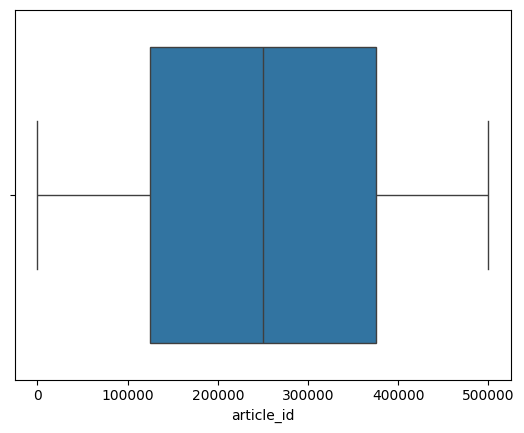

In [14]:
sns.boxplot(x="article_id",data=df)

<Axes: xlabel='title_length'>

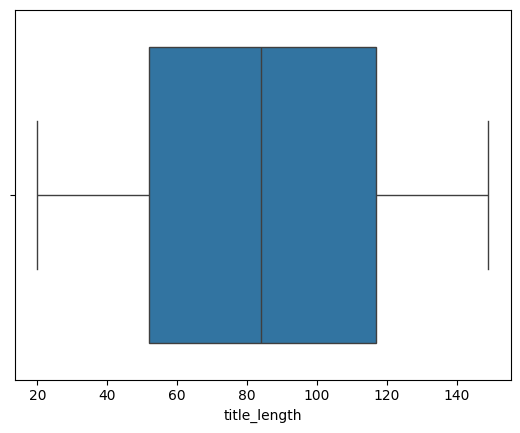

In [15]:
sns.boxplot(x="title_length",data=df)

<Axes: xlabel='text_length'>

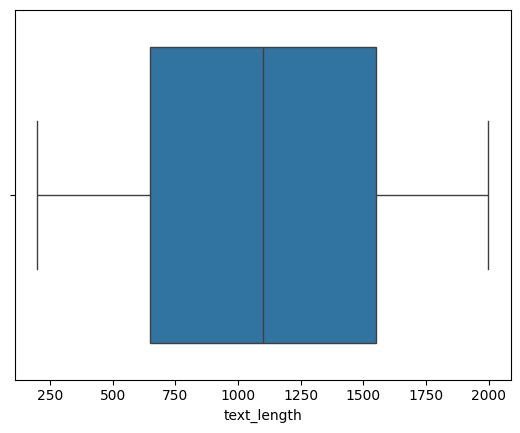

In [16]:
sns.boxplot(x="text_length",data=df)

<Axes: xlabel='num_shares'>

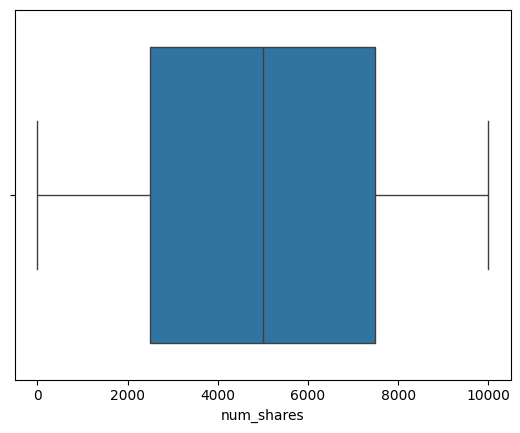

In [17]:
sns.boxplot(x="num_shares",data=df)

<Axes: xlabel='num_likes'>

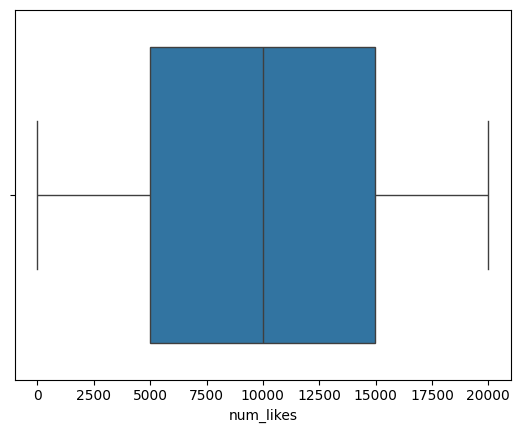

In [18]:
sns.boxplot(x="num_likes",data=df)

<Axes: xlabel='num_comments'>

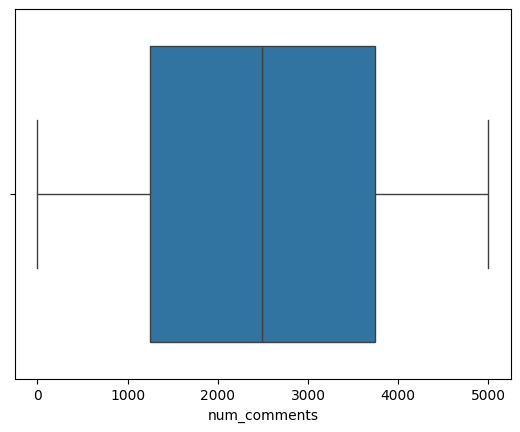

In [19]:
sns.boxplot(x="num_comments",data=df)

<Axes: xlabel='sentiment_score'>

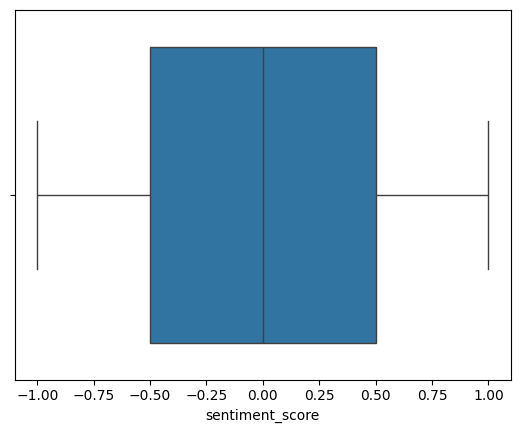

In [20]:
sns.boxplot(x="sentiment_score",data=df)

<Axes: xlabel='subjectivity'>

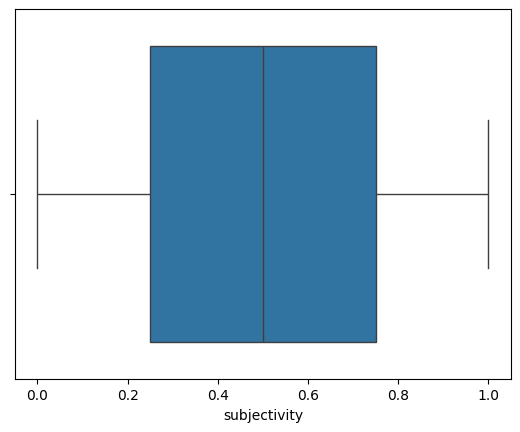

In [21]:
sns.boxplot(x="subjectivity",data=df)

<Axes: xlabel='source_reliability'>

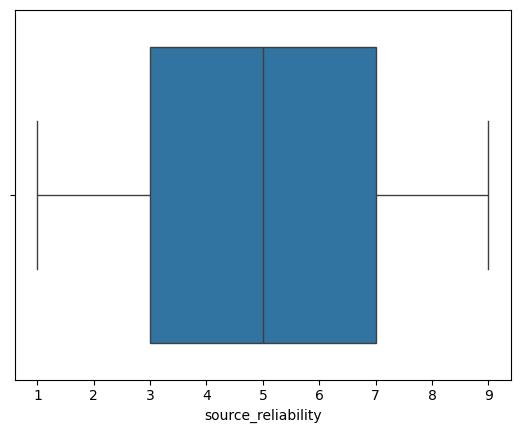

In [22]:
sns.boxplot(x="source_reliability",data=df)

<Axes: xlabel='impact_score'>

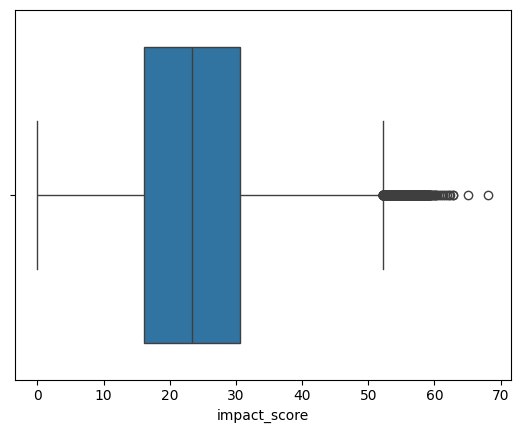

In [23]:
sns.boxplot(x="impact_score",data=df)

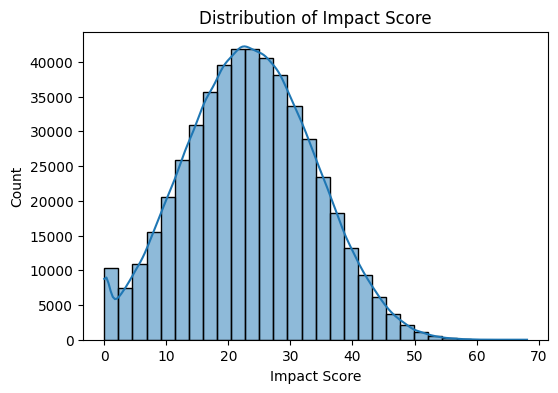

In [24]:
plt.figure(figsize=(6,4))
sns.histplot(df["impact_score"], bins=30, kde=True)
plt.title("Distribution of Impact Score")
plt.xlabel("Impact Score")
plt.show()

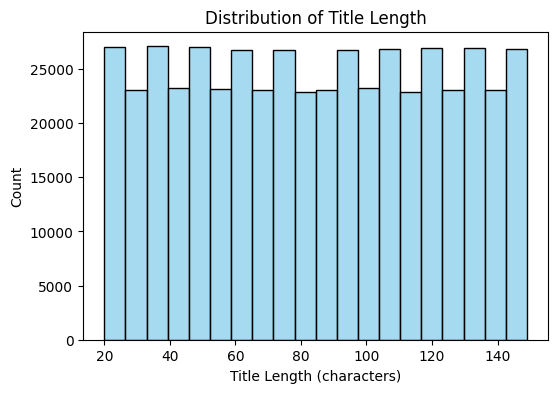

In [25]:
plt.figure(figsize=(6,4))
sns.histplot(df["title_length"], bins=20, color="skyblue")
plt.title("Distribution of Title Length")
plt.xlabel("Title Length (characters)")
plt.show()

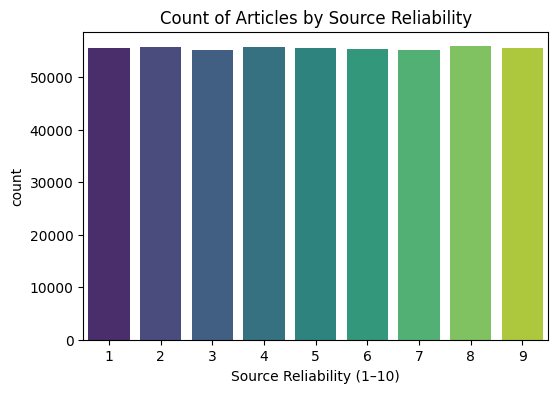

In [26]:
plt.figure(figsize=(6,4))
sns.countplot(x="source_reliability", data=df, palette="viridis")
plt.title("Count of Articles by Source Reliability")
plt.xlabel("Source Reliability (1–10)")
plt.show()

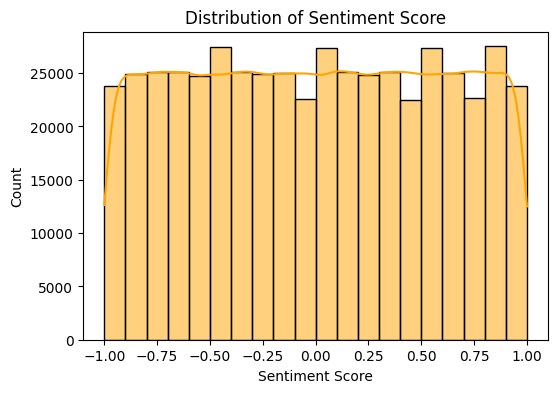

In [27]:

plt.figure(figsize=(6,4))
sns.histplot(df["sentiment_score"], bins=20, kde=True, color="orange")
plt.title("Distribution of Sentiment Score")
plt.xlabel("Sentiment Score")
plt.show()

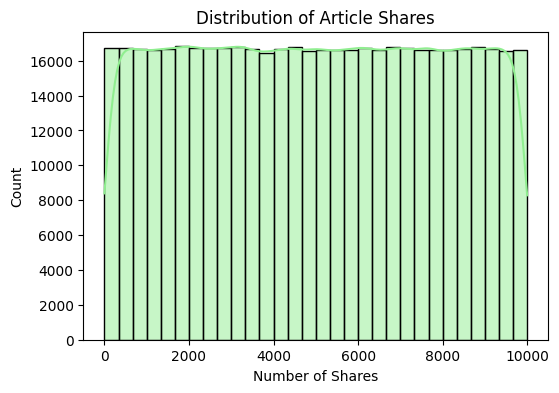

In [29]:
plt.figure(figsize=(6,4))
sns.histplot(df["num_shares"], bins=30, color="lightgreen", kde=True)
plt.title("Distribution of Article Shares")
plt.xlabel("Number of Shares")
plt.show()


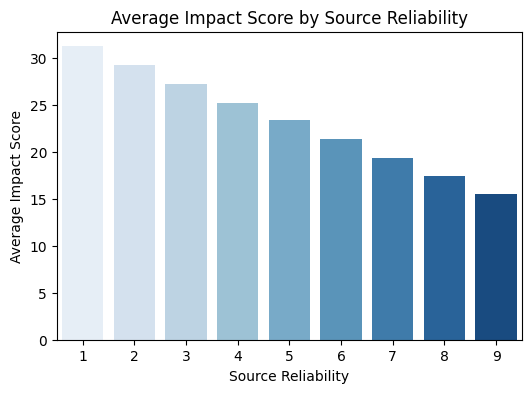

In [31]:
plt.figure(figsize=(6,4))
sns.barplot(x="source_reliability", y="impact_score", data=df, ci=None, palette="Blues")
plt.title("Average Impact Score by Source Reliability")
plt.xlabel("Source Reliability")
plt.ylabel("Average Impact Score")
plt.show()


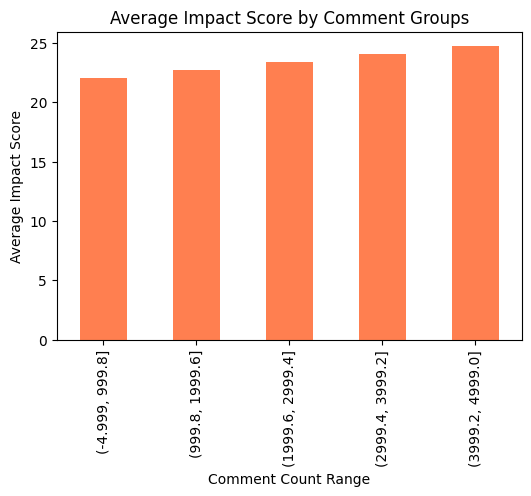

In [34]:
df["comments_bin"] = pd.cut(df["num_comments"], bins=5)
plt.figure(figsize=(6,4))
df.groupby("comments_bin")["impact_score"].mean().plot(kind="bar", color="coral")
plt.title("Average Impact Score by Comment Groups")
plt.xlabel("Comment Count Range")
plt.ylabel("Average Impact Score")
plt.show()

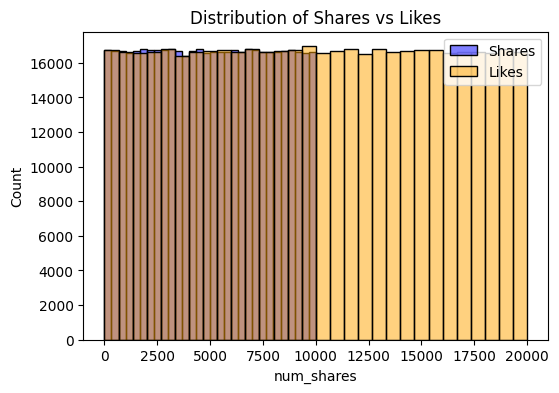

In [35]:
plt.figure(figsize=(6,4))
sns.histplot(df["num_shares"], bins=30, color="blue", alpha=0.5, label="Shares")
sns.histplot(df["num_likes"], bins=30, color="orange", alpha=0.5, label="Likes")
plt.legend()
plt.title("Distribution of Shares vs Likes")
plt.show()

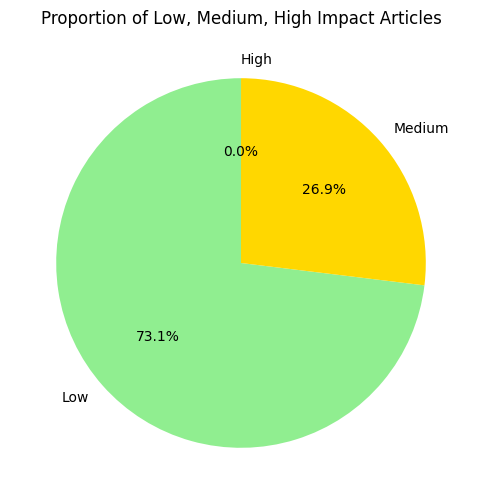

In [36]:
df["impact_category"] = pd.cut(df["impact_score"], bins=[0,30,60,100], labels=["Low","Medium","High"])
impact_counts = df["impact_category"].value_counts()
plt.figure(figsize=(6,6))
plt.pie(impact_counts, labels=impact_counts.index, autopct='%1.1f%%', startangle=90, colors=["lightgreen","gold","salmon"])
plt.title("Proportion of Low, Medium, High Impact Articles")
plt.show()

In [37]:
num=df.select_dtypes(include='number')
num

,article_id,title_length,text_length,num_shares,num_likes,num_comments,sentiment_score,subjectivity,source_reliability,impact_score
0,1,122,1401,6162,10086,4927,0.12,0.44,9,15.749509
1,2,112,778,3384,10222,4145,0.76,0.33,8,22.413467
2,3,34,441,3434,2759,1794,-0.63,0.10,6,9.419026
3,4,126,1594,3306,4655,2880,0.04,0.26,8,14.423110
4,5,91,621,5037,5020,910,0.86,0.99,7,24.117044
...,...,...,...,...,...,...,...,...,...,...
499995,499996,39,1578,2910,19267,1586,-0.66,0.16,3,30.730278
499996,499997,105,1186,3243,15503,4067,-0.95,0.87,1,18.833909
499997,499998,78,1445,5518,7398,2240,0.35,0.31,7,20.512097
499998,499999,118,1536,3543,657,2618,-0.31,0.66,7,16.916508


In [38]:
correl=num.corr()
correl

,article_id,title_length,text_length,num_shares,num_likes,num_comments,sentiment_score,subjectivity,source_reliability,impact_score
article_id,1.000000,-0.001021,0.000127,0.000560,0.000312,0.000908,0.000899,0.000957,-0.000987,0.000657
title_length,-0.001021,1.000000,-0.000070,0.001215,0.002796,-0.000583,-0.001195,-0.000376,-0.000726,0.002677
text_length,0.000127,-0.000070,1.000000,-0.000368,-0.001146,0.000699,0.000688,0.000294,-0.000096,-0.000990
num_shares,0.000560,0.001215,-0.000368,1.000000,-0.000101,0.000480,0.000734,-0.001480,0.000635,0.276032
num_likes,0.000312,0.002796,-0.001146,-0.000101,1.000000,0.001215,0.000093,0.001273,-0.001175,0.369628
num_comments,0.000908,-0.000583,0.000699,0.000480,0.001215,1.000000,0.000286,0.000381,-0.001998,0.093678
sentiment_score,0.000899,-0.001195,0.000688,0.000734,0.000093,0.000286,1.000000,-0.001290,0.001369,0.553190
subjectivity,0.000957,-0.000376,0.000294,-0.001480,0.001273,0.000381,-0.001290,1.000000,0.001102,-0.001900
source_reliability,-0.000987,-0.000726,-0.000096,0.000635,-0.001175,-0.001998,0.001369,0.001102,1.000000,-0.492959
impact_score,0.000657,0.002677,-0.000990,0.276032,0.369628,0.093678,0.553190,-0.001900,-0.492959,1.000000


<Axes: >

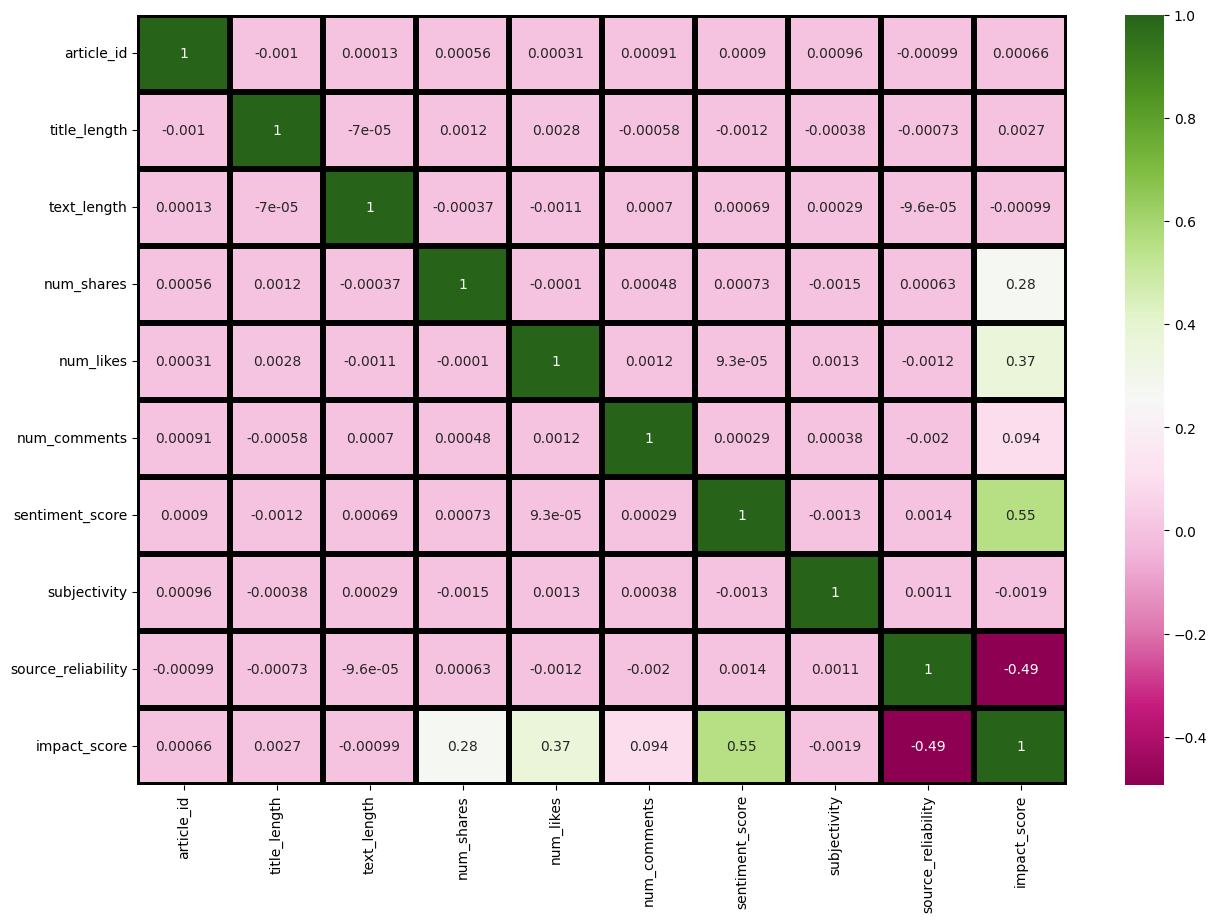

In [39]:
plt.figure(figsize=(15,10))
sns.heatmap(num.corr(),annot=True,linewidths=4,linecolor='k',cmap='PiYG')

In [40]:
dataset=pd.get_dummies(df,dtype=int,drop_first=True) 
dataset

,article_id,title_length,text_length,num_shares,num_likes,num_comments,sentiment_score,subjectivity,source_reliability,impact_score,"comments_bin_(999.8, 1999.6]","comments_bin_(1999.6, 2999.4]","comments_bin_(2999.4, 3999.2]","comments_bin_(3999.2, 4999.0]",impact_category_Medium,impact_category_High
0,1,122,1401,6162,10086,4927,0.12,0.44,9,15.749509,0,0,0,1,0,0
1,2,112,778,3384,10222,4145,0.76,0.33,8,22.413467,0,0,0,1,0,0
2,3,34,441,3434,2759,1794,-0.63,0.10,6,9.419026,1,0,0,0,0,0
3,4,126,1594,3306,4655,2880,0.04,0.26,8,14.423110,0,1,0,0,0,0
4,5,91,621,5037,5020,910,0.86,0.99,7,24.117044,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,499996,39,1578,2910,19267,1586,-0.66,0.16,3,30.730278,1,0,0,0,1,0
499996,499997,105,1186,3243,15503,4067,-0.95,0.87,1,18.833909,0,0,0,1,0,0
499997,499998,78,1445,5518,7398,2240,0.35,0.31,7,20.512097,0,1,0,0,0,0
499998,499999,118,1536,3543,657,2618,-0.31,0.66,7,16.916508,0,1,0,0,0,0


In [41]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   article_id                     500000 non-null  int64  
 1   title_length                   500000 non-null  int32  
 2   text_length                    500000 non-null  int32  
 3   num_shares                     500000 non-null  int32  
 4   num_likes                      500000 non-null  int32  
 5   num_comments                   500000 non-null  int32  
 6   sentiment_score                500000 non-null  float64
 7   subjectivity                   500000 non-null  float64
 8   source_reliability             500000 non-null  int32  
 9   impact_score                   500000 non-null  float64
 10  comments_bin_(999.8, 1999.6]   500000 non-null  int64  
 11  comments_bin_(1999.6, 2999.4]  500000 non-null  int64  
 12  comments_bin_(2999.4, 3999.2] 

In [42]:
X=dataset.drop(['impact_score'],axis=1)
Y=dataset['impact_score']

In [43]:
x_train, x_test,y_train, y_test = train_test_split(X, Y, test_size=0.2)


In [44]:
print('Shape of X train is-', x_train.shape)

print('Shape of X_test is-', x_test.shape)

print('Shape of y_train is-' ,y_train.shape)

print('Shape of y_test is-', y_test.shape)

Shape of X train is- (400000, 15)
Shape of X_test is- (100000, 15)
Shape of y_train is- (400000,)
Shape of y_test is- (100000,)


In [45]:
reg = LinearRegression()

In [46]:
reg.fit(x_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [47]:
reg.predict(x_test)

array([27.22218971, 24.08105568, 41.62592933, ..., 16.80054371,
       25.01936474, 12.10708069], shape=(100000,))

In [48]:
r2_score(y_test,reg.predict(x_test))

0.8234086202007613